In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import glob
import os

img_path =  glob.glob('img_test/*.png')
img = []
for i in img_path:
    img.append(cv2.imread(i,0))

# Introducción a la compresión de imágenes

<img src="img/dcaruso.png" width="70" align="right"/>

*Cuando el tamaño si importa*


[David Caruso](https://www.linkedin.com/in/david-caruso/)

# Intro






# Intro

### Qué es una imagen?

# Intro

Qué es una imagen?

![img](img/what_is_image.png)

# Intro

Por qué comprimir?

* Necesito espacio en disco.
* Mi página web iría más rápido.
* Mi algoritmo de procesamiento podría ir más rápido.

...
![king](img/internet_king.gif)


## Espacio de píxeles

El espacio de píxeles es inmenso!

Una imagen de 20x20 con un bit por píxel

puede representar $2^{400}$ tipos de imágenes distintas!

![img_space](img/img_space.jpg)

<iframe width="300" height="150" src="https://www.youtube.com/embed/Dt2WYkqZfbs?controls=0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>


# Compresión sin pérdida

## RLE

RLE: Run Length Encoding

![rle](img/rle.png)


In [10]:
def RLE_encoder(img, sep=0x100):
    r = []
    count = 0
    val = img[0][0]
    for i in img.flatten():
        if i == val:
            count += 1
        else:
            if count==1:
                r.append(val)
            else:
                r.append(sep)
                r.append(val)
                r.append(count)             
                count=1
            val = i
    return r

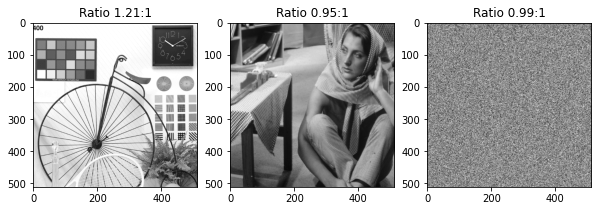

In [11]:
fig = plt.figure(figsize=(10, 10))
columns = len(img)
rows = 1
for e, i in enumerate(range(1, columns*rows +1)):
    enc_img = RLE_encoder(img[e])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[e], cmap='gray')
    plt.title(f"Ratio {(img[e].size/len(enc_img)):.2f}:1")


## Huffman coding


<img src="img/huffman_tree.png" alt="huffman-tree" width="400" align="center"/>


> Huffman tree generated from the exact frequencies of the text "this is an example of a huffman tree". The frequencies and codes of each character are below. Encoding the sentence with this code requires 135 (or 147) bits, as opposed to 288 (or 180) bits if 36 characters of 8 (or 5) bits were used. (This assumes that the code tree structure is known to the decoder and thus does not need to be counted as part of the transmitted information.)

In [15]:
from dahuffman import HuffmanCodec

def huffman_encoder(img):
    codec = HuffmanCodec.from_data(img.tobytes())
    count = dict(sorted(Counter(img.tobytes()).items()))
    enc_img = codec.encode(img.tobytes())
    return enc_img, count


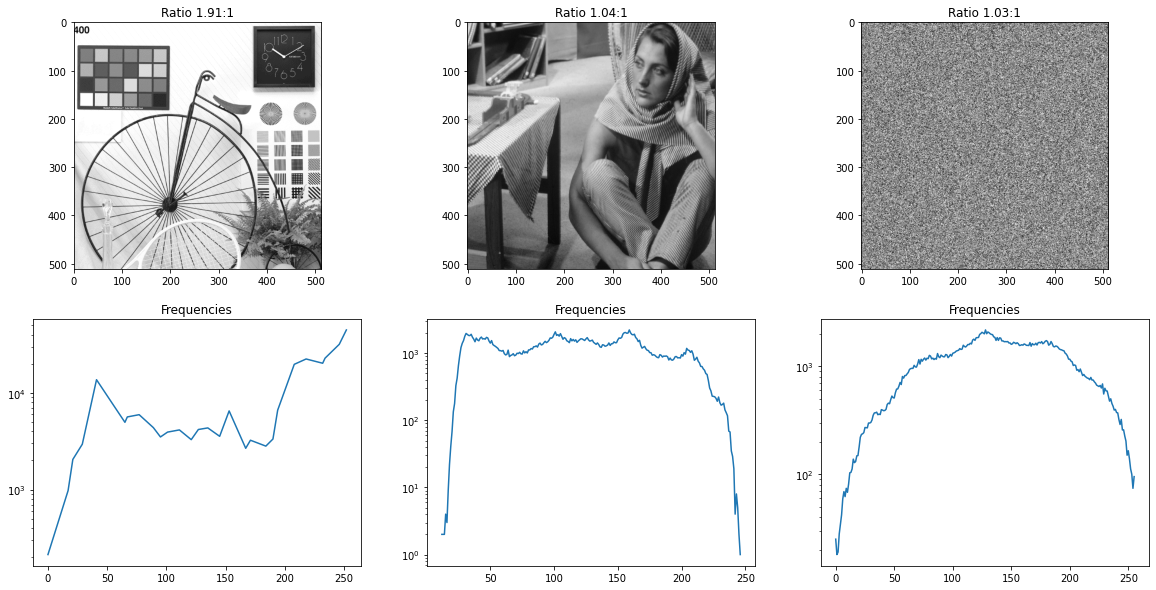

In [59]:
fig = plt.figure(figsize=(20, 10))
columns = len(img)
rows = 2
for e, i in enumerate(range(1, columns +1)):
    enc_img, count = huffman_encoder(img[e])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[e], cmap='gray')
    plt.title(f"Ratio {(img[e].size/len(enc_img)):.2f}:1")
    fig.add_subplot(rows, columns, i+columns)
    plt.plot(count.keys(), count.values())
    plt.yscale("log")
    plt.title("Frequencies")

## Aritmética

Por ejemplo, haciendo diferencia entre pixeles vecinos... 

![diff_huff](img/diff_huffman.png)

*todos los vecinos se parecen un poco*


In [18]:
def diff_huffman(img):
    diff = np.diff(img)
    codec = HuffmanCodec.from_data(diff.tobytes())
    count = dict(sorted(Counter(diff.tobytes()).items()))
    enc_img = codec.encode(diff.tobytes())
    return enc_img, count


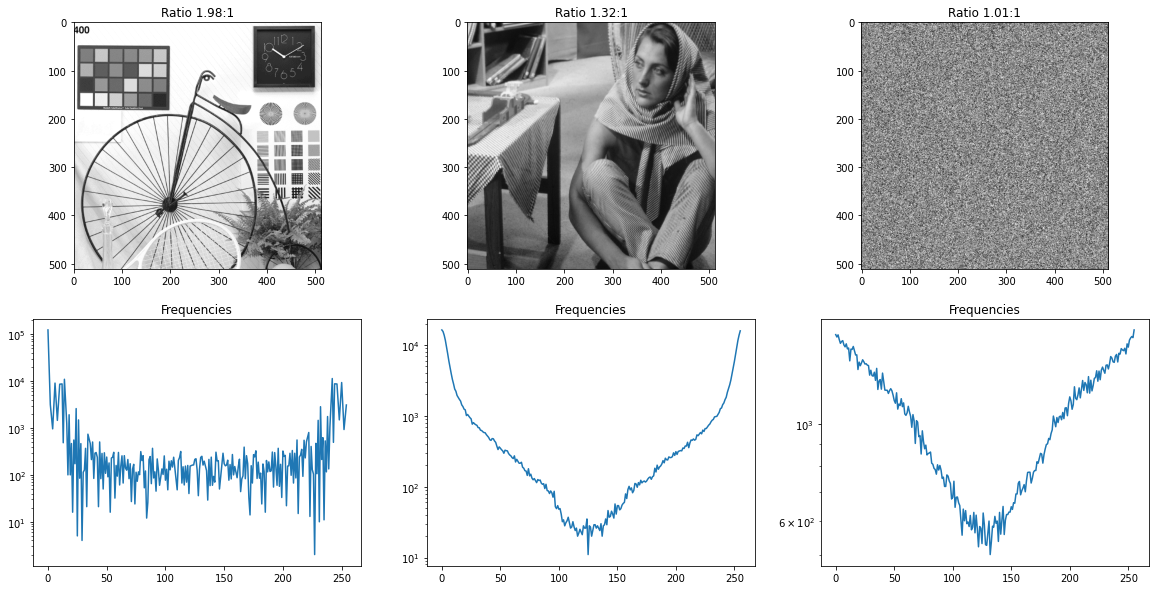

In [17]:
fig = plt.figure(figsize=(20, 10))
columns = len(img)
rows = 2
for e, i in enumerate(range(1, columns +1)):
    enc_img, count = diff_huffman(img[e])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[e], cmap='gray')
    plt.title(f"Ratio {(img[e].size/len(enc_img)):.2f}:1")
    fig.add_subplot(rows, columns, i+columns)
    plt.plot(count.keys(), count.values())
    plt.yscale("log")
    plt.title("Frequencies")

# Compresión con pérdida



## Usando FFT


![fft2d](img/fft2d_comp.png)

In [52]:
def fft2d_comp(img, thresh=0.0004):
    sp_img = np.fft.fft2(img)
    sp_img = np.where((abs(sp_img)/np.max(abs(sp_img)))<=thresh,0, sp_img)
    enc_len = len(np.where(abs(sp_img)!=0)[0])
    img_comp= 255+abs(np.fft.ifft2(sp_img))
    return img_comp, enc_len


In [63]:
def plot_fft2d(img, i, columns, rows):
    img_comp, enc_len = fft2d_comp(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_comp[200:400,300:500], cmap='gray')
    plt.title(f"Ratio {(img.size/enc_len):.2f}:1")
    fig.add_subplot(rows, columns, i+columns)
    plt.imshow(img[200:400,300:500], cmap='gray')
    plt.title("Detail original")
    fig.add_subplot(rows, columns, i+columns*2)
    sp = abs(np.fft.fftshift(np.fft.fft2(img)))
    plt.imshow((sp/np.max(sp)*25000).astype(np.uint8), cmap='gray')

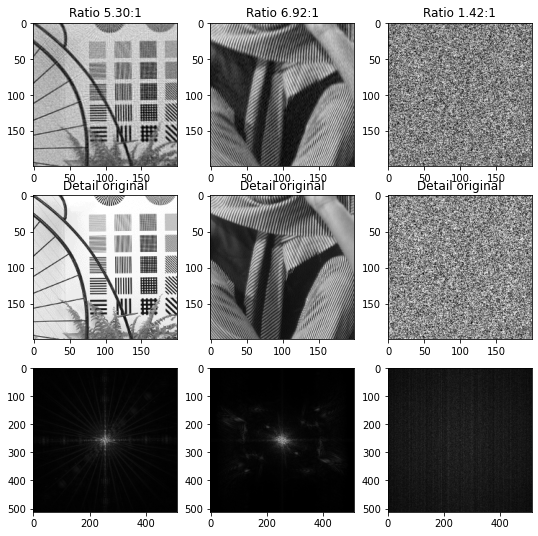

In [66]:
fig = plt.figure(figsize=(9, 9))
columns = len(img)
rows = 3
for e, i in enumerate(range(1, columns +1)):
    plot_fft2d(img[e],i, columns, rows)  


## Usando Wavelet

![wavelet](img/db_wavelet.png)

In [95]:
import pywt

def wavelet_comp(img,thresh=0.013, wavelet='db2'):
    coeffs = pywt.wavedec2(img-np.mean(img), wavelet=wavelet, level=4)
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    norm = abs(coeff_arr)
    coef_filt = np.where((abs(coeff_arr)/np.max(abs(coeff_arr))<=thresh),0, coeff_arr)
    enc_len= len(np.where(coef_filt!=0)[0])
    coeffs_filt = pywt.array_to_coeffs(coef_filt, coeff_slices, output_format='wavedec2')
    img_dec = pywt.waverec2(coeffs_filt, wavelet=wavelet)
    return img_dec, enc_len

In [96]:
def plot_wavelet(img, i, columns, rows, thresh=0.013):
    img_comp, enc_len = wavelet_comp(img, thresh=0.013)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_comp[200:400,300:500], cmap='gray')
    plt.title(f"Ratio {(img.size/enc_len):.2f}:1")
    fig.add_subplot(rows, columns, i+columns)
    plt.imshow(img[200:400,300:500], cmap='gray')
    plt.title("Detail original")

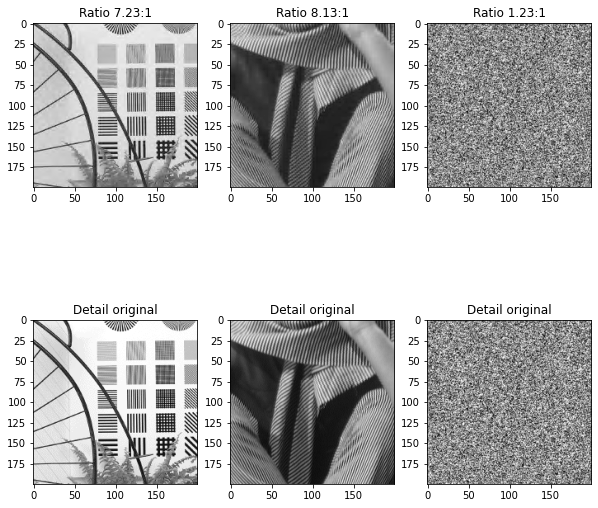

In [97]:
fig = plt.figure(figsize=(10, 10))
columns = len(img)
rows = 2
for e, i in enumerate(range(1, columns +1)):
    plot_wavelet(img[e],i, columns, rows)

## JPEG

![jpeg_block](img/jpeg_block.png)


### DCT

![jpeg_A](img/A_jpeg.gif)
![dct](img/dct.png)

### Quantization

![quantization](img/quantization.png)
![rquant](img/result_quant.png)

### Zig-Zag

![zig-zag](img/zig_zag.png)

### RLE + Huffman

![rquant](img/result_quant.png)

```console
−26,−3,0,−3,−2,−6,2,−4,1,−3,1,1,5,1,2,−1,1,−1,2,0,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
```

In [105]:
def jpeg_comp(img, quality=20):
    o = cv2.imwrite('img_test/test.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    new_size = os.path.getsize('img_test/test.jpg')
    img_comp = cv2.imread('img_test/test.jpg')
    return img_comp, new_size


In [111]:
def plot_jpeg(img, i, columns, rows, quality=20):
    img_comp, enc_len = jpeg_comp(img, quality=quality)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_comp, cmap='gray')
    plt.title(f"Ratio {(img.size/enc_len):.2f}:1")
    fig.add_subplot(rows, columns, i+columns)
    plt.imshow(img_comp[200:400,300:500], cmap='gray')
    plt.title("Detail compressed")
    fig.add_subplot(rows, columns, i+columns*2)
    plt.imshow(img[200:400,300:500], cmap='gray')
    plt.title("Detail original")

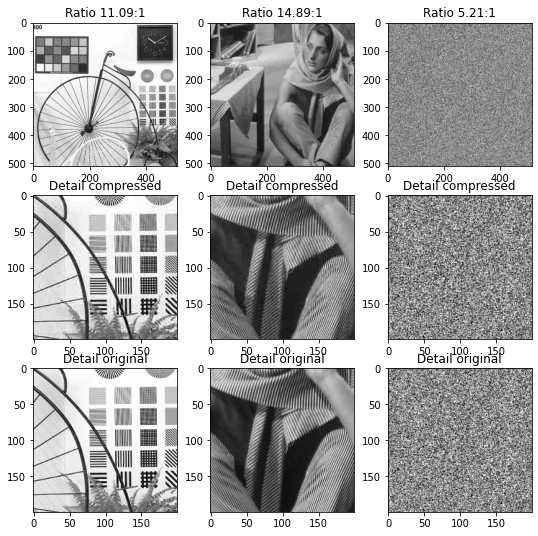

In [112]:
fig = plt.figure(figsize=(9, 9))
columns = len(img)
rows = 3
for e, i in enumerate(range(1, columns +1)):
    plot_jpeg(img[e], i, columns, rows, quality=20)

<img src="img/dcaruso_c.png" width="70" align="right"/>

<center><h1> Muchas gracias!</h1></center>

#### [David Caruso](https://www.linkedin.com/in/david-caruso/)